In [1]:
import numpy as np
from MDAnalysis.lib.pkdtree import Periodic_cKDTree
from gridlocal import FastNS

# Single Queries

In [2]:
def single_grid_build(coords, radius, box=None):
    gr = FastNS(box)
    gr.set_coords(coords)
    gr.set_cutoff(radius)
    gr.prepare()
    return gr
def single_grid_query(struct, query):
    results = struct.search(query)
    indices = results.get_indices()
    if indices:
        indices = np.sort(results.get_indices())
    return indices[0]

In [94]:
def single_cKDT_build(coords, radius, box=None):
    tree = Periodic_cKDTree(box=box)
    tree.set_coords(coords, cutoff=radius)
    return tree
def single_cKDT_query(struct, query, radius):
    return struct.search(query, radius)

In [9]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

## Check

In [123]:
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
radius = 4.
query = np.array([1., 1., 1.], dtype=np.float32)
Npoints = 10000

In [124]:
coords = get_coords(box, Npoints)

In [125]:
grid = single_grid_build(coords, radius, box)

In [126]:
grid_indices = single_grid_query(grid, query)

In [127]:
grid_indices

array([6438])

In [128]:
ckd = single_cKDT_build(coords, radius, box)

In [129]:
ckd_indices = single_cKDT_query(ckd, query, radius)

In [130]:
ckd_indices

array([6438])

In [131]:
np.testing.assert_equal(ckd_indices, grid_indices)

# Benchmarks

* Number of points

In [3]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import itertools
from tqdm import tqdm_notebook
from collections import defaultdict

In [135]:
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = np.logspace(2, 5, num = 10, dtype = np.int)
query = np.array([1.,1.,1.], dtype = np.float32) ## Close to the one of the phases

In [136]:
from tqdm import tqdm_notebook

res_build = defaultdict(list)
res_query = defaultdict(list)
res_total = defaultdict(list)

for N in tqdm_notebook(np.unique(npoints)):
    coords = get_coords(box, N)
    
    # Build
    ckd = single_cKDT_build(coords, cutoff, box)
    grid = single_grid_build(coords, cutoff, box)
    
    # Periodic_cKDTree
    qres = %timeit -q -o single_cKDT_query(ckd, query, cutoff)
    res_query['ckdtree'].append(qres.average)
    
    bres = %timeit -q -o single_cKDT_build(coords, cutoff, box)
    res_build['ckdtree'].append(bres.average)
    
    res_total['ckdtree'].append(bres.average + qres.average)
    
    # GridSearch
    qres = %timeit -q -o single_grid_query(grid, query)
    res_query['gridsearch'].append(qres.average)
    
    bres = %timeit -q -o single_grid_build(coords, cutoff, box)
    res_build['gridsearch'].append(bres.average)
    res_total['gridsearch'].append(bres.average + qres.average)

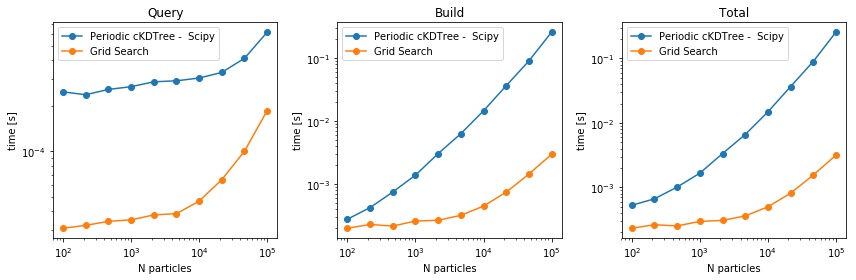

In [138]:
fig, axes = plt.subplots(ncols = 3, figsize = plt.figaspect(1/3))

ax = axes[0]

ax.plot(npoints, res_query['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
ax.plot(npoints, res_query['gridsearch'], 'o-', label='Grid Search')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(npoints, res_build['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
ax.plot(npoints, res_build['gridsearch'], 'o-', label='Grid Search')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[2]
ax.plot(npoints, res_total['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
ax.plot(npoints, res_total['gridsearch'], 'o-', label='Grid Search')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total')
ax.legend()

fig.tight_layout()

* Cutoff Distance

In [139]:
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = np.linspace(1, 15, num = 15, dtype=np.float)
npoints = 50000
query = np.array([1.,1.,1.], dtype = np.float32) ## Close to the one of the phases

In [141]:
from tqdm import tqdm_notebook

res2_build = defaultdict(list)
res2_query = defaultdict(list)
res2_total = defaultdict(list)

coords = get_coords(box, npoints)
for cut in tqdm_notebook(np.unique(cutoff)):

    # Build
    ckd = single_cKDT_build(coords, cut, box)
    grid = single_grid_build(coords, cut, box)
    
    # Periodic_cKDTree
    qres = %timeit -q -o single_cKDT_query(ckd, query, cut)
    res2_query['ckdtree'].append(qres.average)
    
    bres = %timeit -q -o single_cKDT_build(coords, cut, box)
    res2_build['ckdtree'].append(bres.average)
    
    res2_total['ckdtree'].append(bres.average + qres.average)
    
    # GridSearch
    qres = %timeit -q -o single_grid_query(grid, query)
    res2_query['gridsearch'].append(qres.average)
    
    bres = %timeit -q -o single_grid_build(coords, cut, box)
    res2_build['gridsearch'].append(bres.average)
    res2_total['gridsearch'].append(bres.average + qres.average)

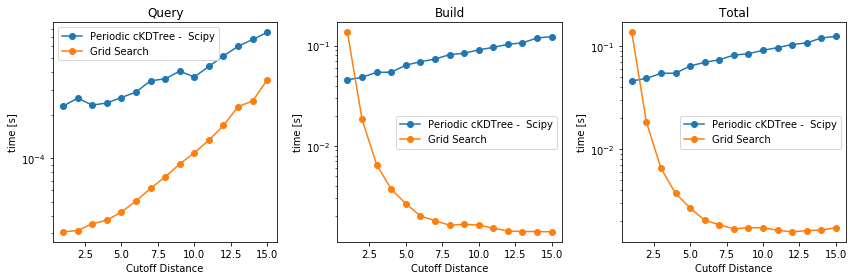

In [143]:
fig, axes = plt.subplots(ncols = 3, figsize = plt.figaspect(1/3))

ax = axes[0]

ax.plot(cutoff, res2_query['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
ax.plot(cutoff, res2_query['gridsearch'], 'o-', label='Grid Search')
ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(cutoff, res2_build['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
ax.plot(cutoff, res2_build['gridsearch'], 'o-', label='Grid Search')
ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Build')
ax.legend()

ax = axes[2]
ax.plot(cutoff, res2_total['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
ax.plot(cutoff, res2_total['gridsearch'], 'o-', label='Grid Search')
ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Total')
ax.legend()

fig.tight_layout()

# Bonded pairs

In [35]:
def grid_bonds(coords, radius, box):
    gr = FastNS(box)
    gr.set_coords(coords)
    gr.set_cutoff(radius)
    gr.prepare()
    results = gr.search(coords)
    indices = results.get_indices()
    pairs = []
    for idx in range(len(coords)):
        if indices[idx].size > 0:
            indices[idx] = sorted(indices[idx])
            for j in indices[idx]:
                if idx < j:
                    pairs.append((idx, j))
    pairs = np.asarray(pairs, dtype=np.int64)        
    return pairs

In [6]:
def ckd_bonds(coords, radius, box):
    tree = Periodic_cKDTree(box=box)
    tree.set_coords(coords, cutoff=radius)
    pairs = tree.search_pairs(radius)
    return pairs

In [7]:
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = 100

In [10]:
coords = get_coords(box, npoints)

In [36]:
pairs_grid= grid_bonds(coords, cutoff, box)

In [37]:
pairs_grid

array([[ 7, 55],
       [ 8, 43],
       [12, 67],
       [21, 71],
       [27, 93],
       [29, 61],
       [33, 99],
       [35, 67],
       [37, 39],
       [38, 64],
       [43, 58],
       [45, 59],
       [49, 65],
       [57, 64],
       [78, 79],
       [78, 85],
       [90, 96]])

In [12]:
pairs_ckd = ckd_bonds(coords, cutoff, box)

In [38]:
pairs_ckd

array([[ 7, 55],
       [ 8, 43],
       [12, 67],
       [21, 71],
       [27, 93],
       [29, 61],
       [33, 99],
       [35, 67],
       [37, 39],
       [38, 64],
       [43, 58],
       [45, 59],
       [49, 65],
       [57, 64],
       [78, 79],
       [78, 85],
       [90, 96]])

In [39]:
np.testing.assert_equal(pairs_ckd, pairs_grid )

# Benchmark

* Number of atoms

In [41]:
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = np.logspace(2, 5, num = 10, dtype = np.int)

In [42]:
from tqdm import tqdm_notebook

result = defaultdict(list)

for N in tqdm_notebook(np.unique(npoints)):
    coords = get_coords(box, N)
    
    # Periodic_cKDTree
    res = %timeit -q -o grid_bonds(coords, cutoff, box)
    result['gridsearch'].append(res.average)
    
    res = %timeit -q -o ckd_bonds(coords, cutoff, box)
    result['ckdtree'].append(res.average)

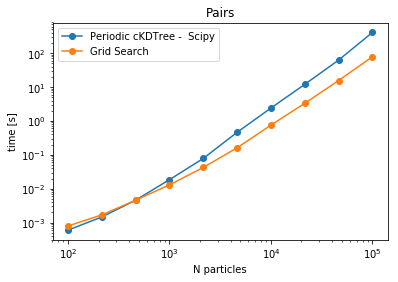

In [44]:
fig, axes = plt.subplots()

axes.plot(npoints, result['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
axes.plot(npoints, result['gridsearch'], 'o-', label='Grid Search')
axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Pairs')
axes.legend()

* Cutoff

In [49]:
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = np.linspace(1, 10, num = 10, dtype = np.float32)
npoints = 10000

In [50]:
from tqdm import tqdm_notebook

result2 = defaultdict(list)

coords = get_coords(box, npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    # Periodic_cKDTree
    res = %timeit -q -o ckd_bonds(coords, cut, box)
    result2['ckdtree'].append(res.average)
    
    # GridSearch
    res = %timeit -q -o grid_bonds(coords, cut, box)
    result2['gridsearch'].append(res.average)

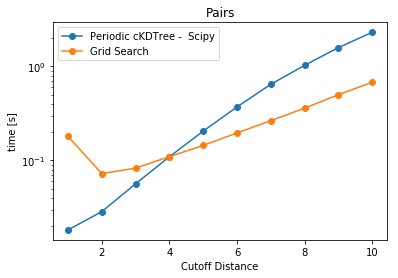

In [51]:
fig, axes = plt.subplots()

axes.plot(cutoff, result2['ckdtree'], 'o-', label='Periodic cKDTree -  Scipy')
axes.plot(cutoff, result2['gridsearch'], 'o-', label='Grid Search')
axes.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Pairs')
axes.legend()

# Real example of guess_bonds

In [63]:
from MDAnalysis.topology import tables
from MDAnalysis.lib.distances import calc_distance
def ckd_guessbonds(coords, atomtypes=None, box=None):
    if atomtypes is None:
        ### Use default values
        atomtype = ['C']
        atomtypes = np.random.choice(atomtype, size = len(coords))
    else:
        ##First check if every atom radius correspond to one particle
        if len(coords) != len(atomtypes):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    vdwradii = tables.vdwradii.copy()
    max_vdw = max([vdwradii[t] for t in atomtypes])
    
    tree = Periodic_cKDTree(box=box)
    tree.set_coords(coords, cutoff=2*max_vdw)
    pairs = tree.search_pairs(2*max_vdw)
    
    for (i, j) in pairs:
        d = (vdwradii[atomtypes[i]] + vdwradii[atomtypes[j]])*fudge_factor
        distance = calc_distance(coords[i], coords[j], box=box)
        if distance < d and distance > lower_bound:
            bonds.append((i, j))
    return tuple(bonds)

In [96]:

def grid_guessbonds(coords, atomtypes=None, box=None):
    if atomtypes is None:
        ### Use default values
        atomtype = ['C']
        atomtypes = np.random.choice(atomtype, size = len(coords))
    else:
        ##First check if every atom radius correspond to one particle
        if len(coords) != len(atomtypes):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    vdwradii = tables.vdwradii.copy()
    max_vdw = max([vdwradii[t] for t in atomtypes])
    
    gr = FastNS(box)
    gr.set_coords(coords)
    gr.set_cutoff(2*max_vdw)
    gr.prepare()
    results = gr.search(coords)
    indices = results.get_indices()
    distance = results.get_distances()
    bonds = []
    for idx in range(len(coords)):
        if indices[idx].size > 0:
            for other_idx, j in enumerate(indices[idx]):
                if((idx < j) and
                   (distance[idx][other_idx] < (vdwradii[atomtypes[idx]] + vdwradii[atomtypes[j]])*fudge_factor)
                   and (distance[idx][other_idx] > lower_bound)):
                    bonds.append((idx, j))        
    return tuple(bonds)

In [54]:
import MDAnalysis as mda
import MDAnalysis.topology.guessers as mda_bf

In [55]:
u1,u2 = mda.Universe('small.gro'), mda.Universe('big.gro')

In [56]:
u1, u2

(<Universe with 12426 atoms>, <Universe with 1564692 atoms>)

In [57]:
# Check the correctness with inbuilt MDAnalysis.topology.guessers.guess_bonds
mda_bonds = mda_bf.guess_bonds(u1.atoms, u1.atoms.positions, u1.dimensions)

In [64]:
ckd_bonds = ckd_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

In [97]:
grid_bonds = grid_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

In [109]:
len(mda_bonds), len(ckd_bonds), len(grid_bonds)

(8284, 8284, 8284)

# Timing

In [114]:
len(u1.atoms)

12426

In [116]:
%timeit -q -o ckd_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

<TimeitResult : 987 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [117]:
%timeit -q -o grid_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

<TimeitResult : 286 ms ± 9.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [115]:
len(u2.atoms)

1564692

In [119]:
%timeit -q -o ckd_guessbonds(u2.atoms.positions,u2.atoms.types, box=u2.dimensions)

<TimeitResult : 1min ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [120]:
%timeit -q -o grid_guessbonds(u2.atoms.positions,u2.atoms.types, box=u2.dimensions)

<TimeitResult : 16.1 s ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>